<a href="https://colab.research.google.com/github/WalterPHD/Ai-Data/blob/main/CreditInformationLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1
First we import

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


Than we load and process the data

In [ ]:
# Load the dataset
df = pd.read_csv('application_train.csv')

#numeric columns to avoid label encoding
df_numeric = df.select_dtypes(include=['number'])

#removing missing values
df_numeric = df_numeric.dropna()

X = df_numeric.drop(columns=["TARGET"])
y = df_numeric["TARGET"]

#splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

#logistic regression with more iterations since it didnt accept 1000
model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

#predicting
y_pred = model.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)

print(f"Baseline Accuracy: {accuracy:.4f}")


Baseline Accuracy: 0.9326


# Problem 2

cheking data

Rows and columns: (307511, 122)
Missing values per column:
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
dtype: int64


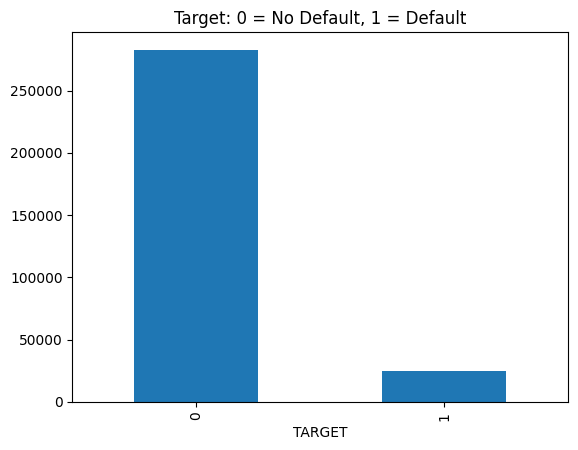

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('application_train.csv')

#size of data
print("Rows and columns:", data.shape)

#showing missing values per column (top 5)
print("Missing values per column:")
print(data.isnull().sum().sort_values(ascending=False).head(5))

#default vs no default
data['TARGET'].value_counts().plot(kind='bar')
plt.title("Target: 0 = No Default, 1 = Default")
plt.show()


preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#numbers only
data_num = data.select_dtypes(include=['number'])

#removing columns with lots of missing data (>30%)
missing = data_num.isnull().mean()
data_num = data_num.drop(columns=missing[missing > 0.3].index)

#using fillna for missing numbers with median
data_num = data_num.fillna(data_num.median())

#separate categorical columns
data_cat = data.select_dtypes(include=['object']).copy()

#filling missing categorical values and convert text to numbers
for col in data_cat.columns:
    data_cat[col] = data_cat[col].fillna('Missing')
    data_cat[col] = LabelEncoder().fit_transform(data_cat[col])

#putting numbers and categories together
data_clean = pd.concat([data_num, data_cat], axis=1)

#features and target cleaning
X = data_clean.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')
y = data_clean['TARGET']

#splitting data into training and test parts (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaleing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


training

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000, solver='lbfgs')
#training
model.fit(X_train, y_train)


LogisticRegression(max_iter=5000)

metric

In [ ]:
from sklearn.metrics import roc_auc_score

#predicting probabilities for test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate AUC score (official metric)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC score: {auc:.4f}")

#loaded data and looked at missing values.
#cleaned data: removed columns with lots of missing data, filled missing numbers, converted text to numbers.
#split data into train and test.
#scaled the data (important for logistic regression).
#trained logistic regression.



AUC score: 0.7398


# Problem 3

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

#loading train data for reference
train = pd.read_csv('application_train.csv')

#loading test data
test = pd.read_csv('application_test.csv')

#maitaing SK_ID_CURR to include in submission later
test_ids = test['SK_ID_CURR']

#preparing to train data same way as before
#numeric columns: drop those with >30% missing in train data
train_num = train.select_dtypes(include=['number'])
missing = train_num.isnull().mean()
drop_cols = missing[missing > 0.3].index

#droping those columns from train numeric and test numeric
train_num = train_num.drop(columns=drop_cols)
test_num = test.select_dtypes(include=['number']).drop(columns=drop_cols, errors='ignore')

#fillna for missing numeric values with median
median_values = train_num.median()
train_num = train_num.fillna(median_values)
test_num = test_num.fillna(median_values)

train_cat = train.select_dtypes(include=['object']).copy()
test_cat = test.select_dtypes(include=['object']).copy()

#fiiling missing and label encode categorical columns using train data labels
from sklearn.preprocessing import OrdinalEncoder

train_cat = train_cat.fillna('Missing')
test_cat = test_cat.fillna('Missing')

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(train_cat)

train_cat_enc = pd.DataFrame(encoder.transform(train_cat), columns=train_cat.columns)
test_cat_enc = pd.DataFrame(encoder.transform(test_cat), columns=test_cat.columns)

#combine numeric + categorical for train and test
# Changed train_cat to train_cat_enc
train_clean = pd.concat([train_num, train_cat_enc], axis=1)
# Changed test_cat to test_cat_enc
test_clean = pd.concat([test_num, test_cat_enc], axis=1)

#droping target and ID from train features
X_train = train_clean.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')
y_train = train_clean['TARGET']

X_test = test_clean.drop(['SK_ID_CURR'], axis=1, errors='ignore')

#scaling features (fit scaler on train, transform train and test)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=5000, solver='lbfgs')
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=5000)

In [ ]:
# Predict probability of default (class 1)
test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]


Submission


In [ ]:
submission = pd.DataFrame({
    'SK_ID_CURR': test_ids,
    'TARGET': test_pred_proba
})

submission.to_csv('submission.csv', index=False)
print("submission.csv created!")


submission.csv created!


In [ ]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.070921
1,100005,0.206707
2,100013,0.027443
3,100028,0.029922
4,100038,0.096510


# Problem 4

In [ ]:
print(data.columns.tolist()) #so i can decide what to add

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

# Occupation type + Name housing type

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#load data
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

#fill missing
for col in ['OCCUPATION_TYPE', 'NAME_HOUSING_TYPE']:
    train[col] = train[col].fillna('Missing')
    test[col] = test[col].fillna('Missing')

#encode
encoder1 = OrdinalEncoder()
X_train_encoded = encoder1.fit_transform(train[['OCCUPATION_TYPE', 'NAME_HOUSING_TYPE']])
X_test_encoded = encoder1.transform(test[['OCCUPATION_TYPE', 'NAME_HOUSING_TYPE']])

#split and train
y = train['TARGET']
X_tr, X_val, y_tr, y_val = train_test_split(X_train_encoded, y, test_size=0.2, random_state=42)

model1 = LogisticRegression(max_iter=1000)
model1.fit(X_tr, y_tr)
val_pred1 = model1.predict_proba(X_val)[:, 1]
auc1 = roc_auc_score(y_val, val_pred1)
print("Pattern 1 AUC:", auc1)


Pattern 1 AUC: 0.5179457173928392


Features used: OCCUPATION_TYPE, NAME_HOUSING_TYPE

Preprocessing:

Missing values filled with "Missing"

Categorical features encoded with OrdinalEncoder

Model: Logistic Regression

Validation AUC: 0.52

# CHILDREN + INCOME_TOTAL + CREDIT

In [ ]:
from sklearn.preprocessing import StandardScaler

#select features
features2 = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
X2 = train[features2].fillna(train[features2].median())
X2_test = test[features2].fillna(train[features2].median())

#scale
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)
X2_test_scaled = scaler2.transform(X2_test)

#split and train
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X2_scaled, y, test_size=0.2, random_state=42)

model2 = LogisticRegression(max_iter=1000)
model2.fit(X_tr2, y_tr2)
val_pred2 = model2.predict_proba(X_val2)[:, 1]
auc2 = roc_auc_score(y_val2, val_pred2)
print("Pattern 2 AUC:", auc2)


Pattern 2 AUC: 0.5311265404705533


Features used: CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT

Preprocessing:

Missing values filled with median

Features scaled using StandardScaler

Model: Logistic Regression

Validation AUC: 0.53

# Name Family Status + Days Registration

In [ ]:
#fill missing
train3 = train[['NAME_FAMILY_STATUS', 'DAYS_REGISTRATION']].copy()
test3 = test[['NAME_FAMILY_STATUS', 'DAYS_REGISTRATION']].copy()
train3['NAME_FAMILY_STATUS'] = train3['NAME_FAMILY_STATUS'].fillna('Missing')
test3['NAME_FAMILY_STATUS'] = test3['NAME_FAMILY_STATUS'].fillna('Missing')

#encode categorical + scale numeric
encoder3 = OrdinalEncoder()
train3[['NAME_FAMILY_STATUS']] = encoder3.fit_transform(train3[['NAME_FAMILY_STATUS']])
test3[['NAME_FAMILY_STATUS']] = encoder3.transform(test3[['NAME_FAMILY_STATUS']])

#fill and scale
train3 = train3.fillna(train3.median())
test3 = test3.fillna(train3.median())
scaler3 = StandardScaler()
X3_scaled = scaler3.fit_transform(train3)
X3_test_scaled = scaler3.transform(test3)

#split and train
X_tr3, X_val3, y_tr3, y_val3 = train_test_split(X3_scaled, y, test_size=0.2, random_state=42)

model3 = LogisticRegression(max_iter=1000)
model3.fit(X_tr3, y_tr3)
val_pred3 = model3.predict_proba(X_val3)[:, 1]
auc3 = roc_auc_score(y_val3, val_pred3)
print("Pattern 3 AUC:", auc3)


Pattern 3 AUC: 0.5439018748743282


Features used: NAME_FAMILY_STATUS, DAYS_REGISTRATION

Preprocessing:

Categorical missing values filled with "Missing", then encoded using OrdinalEncoder

Numeric column filled with median

All columns scaled using StandardScaler

Model: Logistic Regression

Validation AUC: 0.54

# Days Birth + Credit to Income

In [ ]:
#create features
train4 = train[['DAYS_BIRTH', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']].copy()
test4 = test[['DAYS_BIRTH', 'AMT_CREDIT', 'AMT_INCOME_TOTAL']].copy()

#create new column
train4['CREDIT_TO_INCOME'] = train4['AMT_CREDIT'] / train4['AMT_INCOME_TOTAL']
test4['CREDIT_TO_INCOME'] = test4['AMT_CREDIT'] / test4['AMT_INCOME_TOTAL']

#use only age and new feature
X4 = train4[['DAYS_BIRTH', 'CREDIT_TO_INCOME']].fillna(train4.median())
X4_test = test4[['DAYS_BIRTH', 'CREDIT_TO_INCOME']].fillna(train4.median())

#scale
scaler4 = StandardScaler()
X4_scaled = scaler4.fit_transform(X4)
X4_test_scaled = scaler4.transform(X4_test)

#train
X_tr4, X_val4, y_tr4, y_val4 = train_test_split(X4_scaled, y, test_size=0.2, random_state=42)

model4 = LogisticRegression(max_iter=1000)
model4.fit(X_tr4, y_tr4)
val_pred4 = model4.predict_proba(X_val4)[:, 1]
auc4 = roc_auc_score(y_val4, val_pred4)
print("Pattern 4 AUC:", auc4)


Pattern 4 AUC: 0.5860570745178284


Features used: DAYS_BIRTH, CREDIT_TO_INCOME (engineered = AMT_CREDIT / AMT_INCOME_TOTAL)

Preprocessing:

New feature created manually

Missing values filled with median

Scaled using StandardScaler

Model: Logistic Regression

Validation AUC: 0.59

# Name Education type + Days employed

In [ ]:
#prepare data
train5 = train[['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED']].copy()
test5 = test[['NAME_EDUCATION_TYPE', 'DAYS_EMPLOYED']].copy()

train5['NAME_EDUCATION_TYPE'] = train5['NAME_EDUCATION_TYPE'].fillna('Missing')
test5['NAME_EDUCATION_TYPE'] = test5['NAME_EDUCATION_TYPE'].fillna('Missing')

#encode
encoder5 = OrdinalEncoder()
train5[['NAME_EDUCATION_TYPE']] = encoder5.fit_transform(train5[['NAME_EDUCATION_TYPE']])
test5[['NAME_EDUCATION_TYPE']] = encoder5.transform(test5[['NAME_EDUCATION_TYPE']])

#fill and scale
train5 = train5.fillna(train5.median())
test5 = test5.fillna(train5.median())
scaler5 = StandardScaler()
X5_scaled = scaler5.fit_transform(train5)
X5_test_scaled = scaler5.transform(test5)

#train
X_tr5, X_val5, y_tr5, y_val5 = train_test_split(X5_scaled, y, test_size=0.2, random_state=42)

model5 = LogisticRegression(max_iter=1000)
model5.fit(X_tr5, y_tr5)
val_pred5 = model5.predict_proba(X_val5)[:, 1]
auc5 = roc_auc_score(y_val5, val_pred5)
print("Pattern 5 AUC:", auc5)


Pattern 5 AUC: 0.535971501385426


Features used: NAME_EDUCATION_TYPE, DAYS_EMPLOYED

Preprocessing:

Categorical column filled and encoded using OrdinalEncoder

Numeric column filled with median

Scaled using StandardScaler

Model: Logistic Regression

Validation AUC: 0.54

# Posted on kaggle
https://www.kaggle.com/code/alvarosalgado3366/creditinfolearn